In [1]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [2]:
# q1: What routes are we getting?
sql1 ='''
SELECT route, count(route)
FROM ttc.cis_2017
GROUP BY route
ORDER BY route
 '''

print_table(sql1, con)

route,count
301,2682467
304,292092
306,1453126
310,38114
501,57833907
502,5630170
503,2421395
504,35297179
505,22156141
506,32968842


The table shows all the routes and their frequency in 2017 from the table `cis_2017` in database.

In [3]:
# q2: How does data quantity vary by month?
sql2 ='''
SELECT date_part('month', message_datetime) AS month, count(route)
FROM ttc.cis_2017
GROUP BY month
 '''

print_table(sql2, con)

month,count
1.0,19348204
2.0,17537166
3.0,19757409
4.0,18671319
5.0,19431555
6.0,19364757
7.0,19875493
8.0,19758310
9.0,18729240
10.0,19373990


The table shows the frequency of all the routes in 12 months.

In [4]:
# q3: What are duplicate records with same vehicle and message_datetime?

sql3 = '''
select * INTO dzou2.cis_dup
from (
  SELECT *,
  COUNT(1) OVER(PARTITION BY vehicle, message_datetime) AS cnt
  FROM ttc.cis_2017
) dups
where 
dups.cnt > 1    
'''

## The selected data includes 19636 rows of data, so the table is not printed and the data are stored in dzou2.cis_dup. 
## There are some anlysis of the duplicates in the markdown cell. 


# Duplicates analysis #


Total number of of the duplicate vehicle and timestamp: __19636__

Numbers of 

1. exact duplicate: __16736__

2. routes and runs both different in different positions:__186__

3. routes and runs both different in matched positions:__22__

4. same routes different runs in different positions:__1784__

5. same routes different runs in matched positions:__618__

6. same runs different routes in different positions:__178__

7. same runs different routes in matched positions:__112__

 
 
Total number of duplicates sql:
```sql
sql = SELECT count(*) FROM dzou2.cis_dup
```

duplicate types sql:
``` sql
sql = 
--Put all possible duplicate columns into array
WITH grouped AS (SELECT vehicle, message_datetime, 
ARRAY_AGG(route) as routes, ARRAY_AGG(run) as runs, array_agg('[' || latitude || ',' || longitude || ']') as pos
FROM dzou2.cis_dup
GROUP BY vehicle, message_datetime)
--Classify type of  duplication
, classified AS(SELECT vehicle, message_datetime,
CASE WHEN pos[1] = pos[2] AND routes[1] = routes[2] AND runs[1] = runs[2]
THEN 'exact duplicate'
WHEN pos[1] = pos[2] AND routes[1] <> routes[2] AND runs[1] = runs[2] 
THEN 'same runs different routes in matched positions'
WHEN pos[1] <> pos[2] AND routes[1] <> routes[2] AND runs[1] = runs[2] 
THEN 'same runs different routes in different positions'
WHEN pos[1] = pos[2] AND routes[1] = routes[2] AND runs[1] <> runs[2] 
THEN 'same routes different runs in matched positions'
WHEN pos[1] <> pos[2] AND routes[1] = routes[2] AND runs[1] <> runs[2] 
THEN 'same routes different runs in different positions'
WHEN pos[1] = pos[2] AND routes[1] <> routes[2] AND runs[1] <> runs[2] 
THEN 'routes and runs both different in matched positions'
WHEN pos[1] <> pos[2] AND routes[1] <> routes[2] AND runs[1] <> runs[2] 
THEN 'routes and runs both different in different positions'
ELSE 'others'
END AS type_of_dupe
FROM grouped)
--Breakdown of duplication types
SELECT type_of_dupe, COUNT(1)*2 AS count
FROM classified
GROUP BY type_of_dupe
ORDER BY type_of_dupe
```


In [7]:
# q4 part b: How do points per route vary by month?
# The distribution of each route in each month
sql4b = '''
SELECT count(DISTINCT (position, message_datetime)), route, date_part('month', message_datetime) AS month
FROM ttc.cis_2017
GROUP BY route, month
'''

print_table(sql4b, con)


count,route,month
225389,301,1.0
223933,301,2.0
232913,301,3.0
217494,301,4.0
244996,301,5.0
230391,301,6.0
210816,301,7.0
222900,301,8.0
194163,301,9.0
221519,301,10.0


The tables shows the frequency of position of each route per month.

The table does not include the duplicates which idicate the buses appear at the same position and time.

*Position is one of the column in the data*

In [8]:
# the frequency of a run number change for a vehicle in the example of route 504 on 2017-01-30
sqlf = '''
SELECT vehicle, route, run, MIN(message_datetime) run_start, MAX(message_datetime) run_end, MAX(message_datetime) - MIN(message_datetime) run_length
FROM ttc.cis_2017
WHERE date(message_datetime) = '2017-01-30' AND route = '504'
GROUP BY vehicle, route, run
ORDER BY vehicle, run_start
'''

print_table(sqlf, con)

vehicle,route,run,run_start,run_end,run_length
1350,504,51,2017-01-30 21:30:20,2017-01-30 23:59:40,02:29:20
4004,504,28,2017-01-30 06:37:00,2017-01-30 23:59:40,17:22:40
4010,504,2,2017-01-30 06:58:40,2017-01-30 16:01:00,09:02:20
4010,504,30,2017-01-30 16:01:20,2017-01-30 23:59:40,07:58:20
4014,504,19,2017-01-30 05:00:40,2017-01-30 22:41:20,17:40:40
4015,504,40,2017-01-30 05:31:00,2017-01-30 09:04:20,03:33:20
4015,504,14,2017-01-30 09:04:40,2017-01-30 20:22:00,11:17:20
4025,504,43,2017-01-30 07:21:00,2017-01-30 10:37:40,03:16:40
4025,504,23,2017-01-30 10:38:00,2017-01-30 22:19:20,11:41:20
4028,504,8,2017-01-30 00:00:00,2017-01-30 01:54:20,01:54:20


The table shows the time and duration that route 504 changed its run number on 01/30/2017

*run is one of the column in the data*

In [42]:
# pivot table of the issue types by route
sql_types = '''
SELECT type_of_dupe, route, count(*) AS observations
FROM dzou2.cis_dup_groups
WHERE type_of_dupe <> 'exact duplicate'
GROUP BY type_of_dupe, route
ORDER BY type_of_dupe
'''
df = pandasql.read_sql(sql_types, con)
table = pd.pivot_table(df, values='observations', index=['route'], columns=['type_of_dupe'])
table

type_of_dupe,routes and runs both different in different positions,routes and runs both different in matched positions,same routes different runs in different positions,same routes different runs in matched positions,same runs different routes in different positions,same runs different routes in matched positions
route,,,,,,
301,30.0,NaN,2.0,NaN,47.0,33.0
304,NaN,NaN,284.0,NaN,7.0,1.0
306,46.0,NaN,20.0,NaN,14.0,11.0
310,NaN,NaN,NaN,NaN,2.0,NaN
501,5.0,3.0,158.0,48.0,51.0,35.0
502,1.0,1.0,NaN,NaN,7.0,7.0
503,NaN,2.0,8.0,4.0,7.0,7.0
504,37.0,3.0,288.0,100.0,11.0,2.0
505,6.0,2.0,216.0,64.0,3.0,1.0


The pivot tables shows the frequency of each route with each duplicate type

In [40]:
# range of # observations/day for weekday and weekend
sql_week = '''
SELECT count(*) AS observation, date(message_datetime) AS date, 
(CASE WHEN EXTRACT(isodow FROM date(message_datetime)) > 0 AND EXTRACT(isodow FROM date(message_datetime)) < 6
      THEN 'weekday'
      WHEN EXTRACT(isodow FROM date(message_datetime)) = 6 OR EXTRACT(isodow FROM date(message_datetime)) = 7
      THEN 'weekend'
END) AS day
FROM ttc.cis_2017
GROUP BY date
'''
df = pandasql.read_sql(sql_week, con)

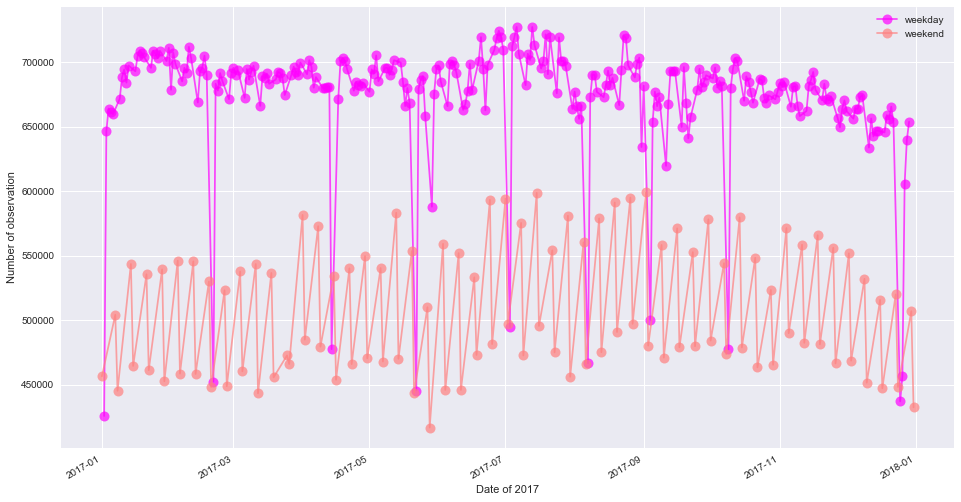

In [46]:
weekend_data = df[(df['day'] == 'weekend')]
weekday_data = df[(df['day'] == 'weekday')]

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 2
cm = plt.get_cmap('spring')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(weekday_data.date, weekday_data.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="weekday", color=colors[0])

ax.plot(weekend_data.date, weekend_data.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="weekend", color=colors[1])

ax.legend()
plt.gcf().autofmt_xdate() 
ax.set_xlabel('Date of 2017')



The graph shows the comparision of the frequency of all the routes on weekdays and weekends.

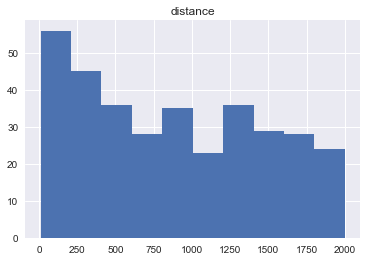

In [2]:
# frequency of distance among unmatched positions (only selected the distances that are less than 2 km)

sql_dist = '''
WITH all_dist AS (
SELECT vehicle, message_datetime, type_of_dupe,
ST_Distance(
        ST_Transform(ST_GeomFromText('POINT(' || substring((overlay(pos[1] placing ' ' from 11 for 1)) from 2 for 20) || ')',4326),26986),
        ST_Transform(ST_GeomFromText('POINT(' || substring((overlay(pos[2] placing ' ' from 11 for 1)) from 2 for 20) || ')',4326),26986)) 
        AS dist
FROM dzou2.cis_dup_groups
WHERE type_of_dupe = 'routes and runs both different in different positions'
OR type_of_dupe = 'same routes different runs in different positions'
OR type_of_dupe = 'same runs different routes in different positions'
GROUP BY vehicle, message_datetime, type_of_dupe, dist
HAVING count(*)>1
ORDER BY dist DESC)
SELECT (dist :: bigint) AS distance
FROM all_dist
WHERE dist < 2000
GROUP BY distance
'''


df_dist = pandasql.read_sql(sql_dist, con)
ax = df_dist.hist()

There are many duplicates in the table cis_2017 with the same vehicle id (`vehicle`) and timestamp (`message_datetime`). In other words, the bus/streecar shows at the different positions at the same time. To compare the distance between two positions for one duplicate, the histogram shows the frenquency of the distance in the duplicates which have the different distance less than 2 kilometres. 

In [3]:
sql_q4a = '''
SELECT count (DISTINCT vehicle) AS observation, route, date_part('month', message_datetime) AS month
FROM ttc.cis_2017
WHERE route = 501 OR route = 504 OR route = 514
GROUP BY route, month
'''

df2 = pandasql.read_sql(sql_q4a, con)

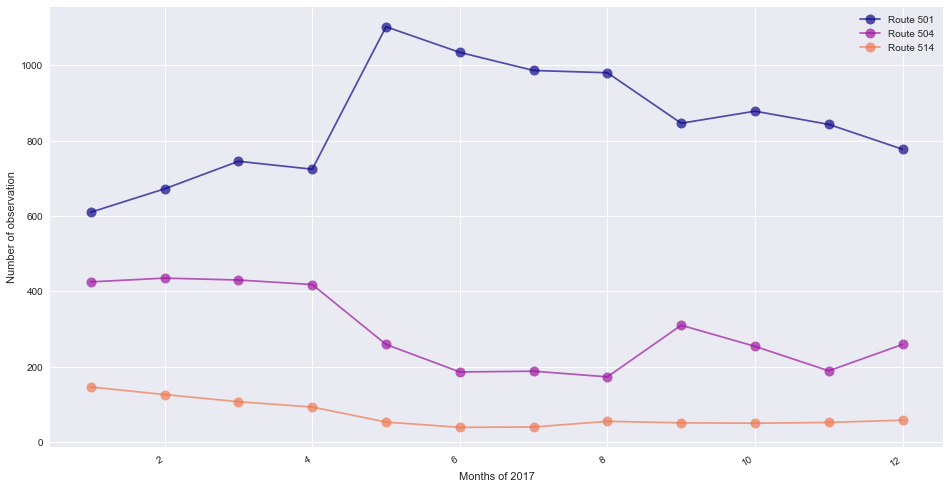

In [32]:
df2_501 = df2[(df2['route'] == 501)]
df2_504 = df2[(df2['route'] == 504)]
df2_514 = df2[(df2['route'] == 514)]



fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 3
cm = plt.get_cmap('plasma')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(df2_501.month, df2_501.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 501", color=colors[0])

ax.plot(df2_504.month, df2_504.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 504", color=colors[1])

ax.plot(df2_514.month, df2_514.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 514", color=colors[2])

ax.legend()
plt.gcf().autofmt_xdate() 
ax.set_xlabel('Months of 2017')
ax.set_ylabel('Number of observation')

# The number of records of routes 501, 504, 504 per month

The graph shows the frequency of route 501, 504, 514 in each month in 2017.

In [24]:
sql_q4b = '''
SELECT count(DISTINCT (position, message_datetime)) AS observation, route, date_part('month', message_datetime) AS month
FROM ttc.cis_2017
GROUP BY route, month
'''

df3 = pandasql.read_sql(sql_q4b, con)

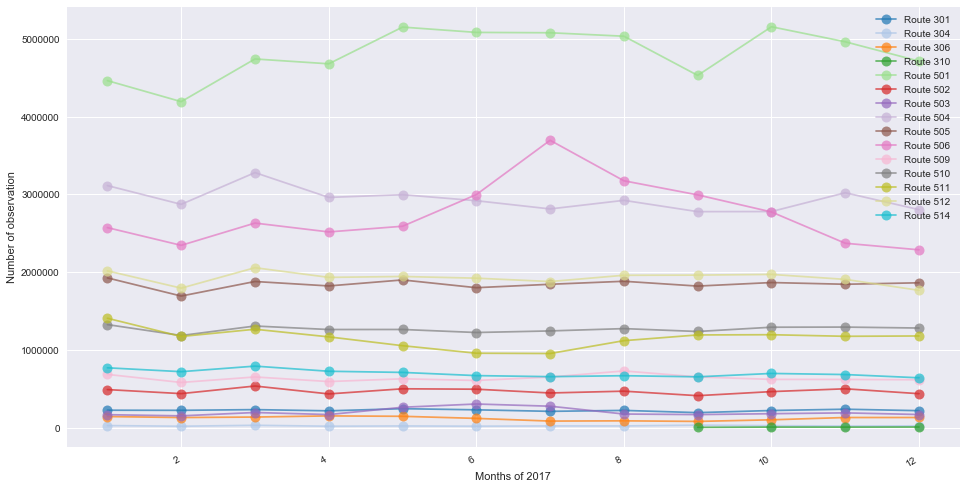

In [31]:
df3_301 = df3[(df3['route'] == 301)]
df3_304 = df3[(df3['route'] == 304)]
df3_306 = df3[(df3['route'] == 306)]
df3_310 = df3[(df3['route'] == 310)]
df3_501 = df3[(df3['route'] == 501)]
df3_502 = df3[(df3['route'] == 502)]
df3_503 = df3[(df3['route'] == 503)]
df3_504 = df3[(df3['route'] == 504)]
df3_505 = df3[(df3['route'] == 505)]
df3_506 = df3[(df3['route'] == 506)]
df3_509 = df3[(df3['route'] == 509)]
df3_510 = df3[(df3['route'] == 510)]
df3_511 = df3[(df3['route'] == 511)]
df3_512 = df3[(df3['route'] == 512)]
df3_514 = df3[(df3['route'] == 514)]




fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 15
cm = plt.get_cmap('tab20')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(df3_301.month, df3_301.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 301", color=colors[0])

ax.plot(df3_304.month, df3_304.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 304", color=colors[1])

ax.plot(df3_306.month, df3_306.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 306", color=colors[2])

ax.plot(df3_310.month, df3_310.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 310", color=colors[3])

ax.plot(df3_501.month, df3_501.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 501", color=colors[4])

ax.plot(df3_502.month, df3_502.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 502", color=colors[5])

ax.plot(df3_503.month, df3_503.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 503", color=colors[6])

ax.plot(df3_504.month, df3_504.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 504", color=colors[7])

ax.plot(df3_505.month, df3_505.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 505", color=colors[8])

ax.plot(df3_506.month, df3_506.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 506", color=colors[9])

ax.plot(df3_509.month, df3_509.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 509", color=colors[10])

ax.plot(df3_510.month, df3_510.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 510", color=colors[11])

ax.plot(df3_511.month, df3_511.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 511", color=colors[12])

ax.plot(df3_512.month, df3_512.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 512", color=colors[13])

ax.plot(df3_514.month, df3_514.observation, marker='o', markersize=10, alpha=0.7,
            linestyle='-', label="Route 514", color=colors[14])

ax.legend()
plt.gcf().autofmt_xdate() 
ax.set_xlabel('Months of 2017')
ax.set_ylabel('Number of observation')

The graph shows the frequency of all the routes in each month in 2017.

In [33]:
sql_365 = '''
SELECT count(DISTINCT (position, message_datetime)) AS observation, route, date(message_datetime) AS message_date
FROM ttc.cis_2017
GROUP BY route, message_date
'''

df4 = pandasql.read_sql(sql_365, con)

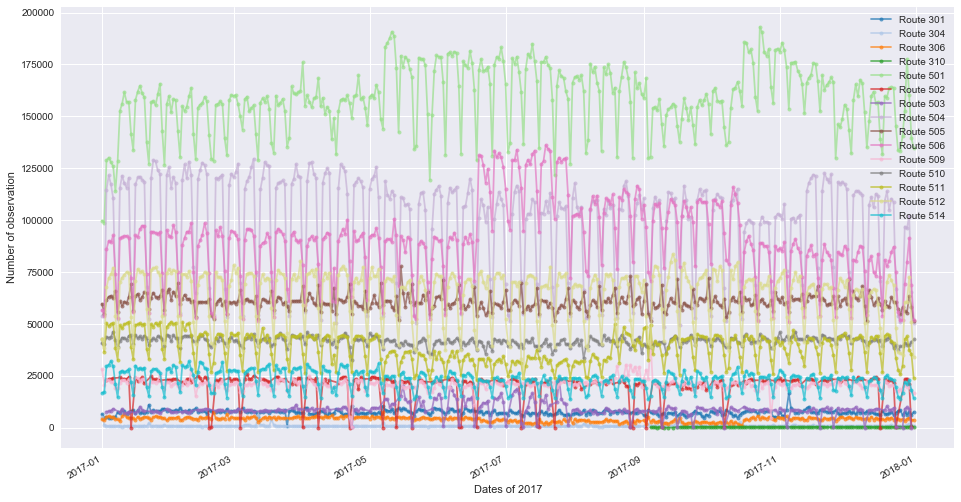

In [36]:
df4_301 = df4[(df4['route'] == 301)]
df4_304 = df4[(df4['route'] == 304)]
df4_306 = df4[(df4['route'] == 306)]
df4_310 = df4[(df4['route'] == 310)]
df4_501 = df4[(df4['route'] == 501)]
df4_502 = df4[(df4['route'] == 502)]
df4_503 = df4[(df4['route'] == 503)]
df4_504 = df4[(df4['route'] == 504)]
df4_505 = df4[(df4['route'] == 505)]
df4_506 = df4[(df4['route'] == 506)]
df4_509 = df4[(df4['route'] == 509)]
df4_510 = df4[(df4['route'] == 510)]
df4_511 = df4[(df4['route'] == 511)]
df4_512 = df4[(df4['route'] == 512)]
df4_514 = df4[(df4['route'] == 514)]




fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 15
cm = plt.get_cmap('tab20')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ax.plot(df4_301.message_date, df4_301.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 301", color=colors[0])

ax.plot(df4_304.message_date, df4_304.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 304", color=colors[1])

ax.plot(df4_306.message_date, df4_306.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 306", color=colors[2])

ax.plot(df4_310.message_date, df4_310.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 310", color=colors[3])

ax.plot(df4_501.message_date, df4_501.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 501", color=colors[4])

ax.plot(df4_502.message_date, df4_502.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 502", color=colors[5])

ax.plot(df4_503.message_date, df4_503.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 503", color=colors[6])

ax.plot(df4_504.message_date, df4_504.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 504", color=colors[7])

ax.plot(df4_505.message_date, df4_505.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 505", color=colors[8])

ax.plot(df4_506.message_date, df4_506.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 506", color=colors[9])

ax.plot(df4_509.message_date, df4_509.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 509", color=colors[10])

ax.plot(df4_510.message_date, df4_510.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 510", color=colors[11])

ax.plot(df4_511.message_date, df4_511.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 511", color=colors[12])

ax.plot(df4_512.message_date, df4_512.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 512", color=colors[13])

ax.plot(df4_514.message_date, df4_514.observation, marker='o', markersize=4, alpha=0.7,
            linestyle='-', label="Route 514", color=colors[14])

ax.legend()
plt.gcf().autofmt_xdate() 
ax.set_xlabel('Dates of 2017')
ax.set_ylabel('Number of observation')

The graph shows the frequency of all the routes on each day in 2017.